### Cross Model Testing (External Dataset Validation)

### Import Packages

In [ ]:
import tensorflow as tf
import numpy as np
from numpy.random import randn
import pathlib
import random
from PIL import Image
import cv2
from matplotlib.image import imread
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob 
import shutil

### Load Images

In [6]:
dest_dir="/content/drive/MyDrive/Testing_Data_Emotions/"
for filename in glob.glob("/content/drive/MyDrive/Testing_Data_Emotions/Happy/*"):
  f=filename[filename.rfind("/")+1:]
  og_file=filename[:filename.rfind("/")+1]
  fname='happy_'+f

  final_name=og_file+fname
  os.rename(filename, final_name)


In [7]:
dest_dir="/content/drive/MyDrive/Testing_Data_Emotions/"
for filename in glob.glob("/content/drive/MyDrive/Testing_Data_Emotions/Sad/*"):
  f=filename[filename.rfind("/")+1:]
  og_file=filename[:filename.rfind("/")+1]
  fname='sad_'+f

  final_name=og_file+fname
  os.rename(filename, final_name)

In [8]:
dest_dir="/content/drive/MyDrive/Testing_Data_Emotions/"
for filename in glob.glob("/content/drive/MyDrive/Testing_Data_Emotions/Neutral/*"):
  f=filename[filename.rfind("/")+1:]
  og_file=filename[:filename.rfind("/")+1]
  fname='neutral_'+f

  final_name=og_file+fname
  os.rename(filename, final_name)

In [9]:
dest_dir="/content/drive/MyDrive/Testing_Data_Emotions/"
for filename in glob.glob("/content/drive/MyDrive/Testing_Data_Emotions/*"):
    files = os.listdir(filename)
    for fname in files:
        shutil.copy2(os.path.join(filename,fname), dest_dir)
        

In [10]:
!rm -r /content/drive/MyDrive/Testing_Data_Emotions/Neutral

In [11]:
!rm -r /content/drive/MyDrive/Testing_Data_Emotions/Happy

In [12]:
!rm -r /content/drive/MyDrive/Testing_Data_Emotions/Sad

In [3]:
test_data=pd.DataFrame()
filenames=[]
labels=[]
for f in glob.glob("/content/drive/MyDrive/Testing_Data_Emotions/*"):
  filenames.append(f)
  temp=f[f.rfind("/")+1:]
  label=temp[:temp.find('_')]
  if label=='happy':
    labels.append(0)

  
  elif label=='sad':
    labels.append(1)


  else:
    labels.append(2)

In [4]:
test_data['filename']=filenames
test_data['labels']=labels


In [5]:
test_data

,filename,labels
0,/content/drive/MyDrive/Testing_Data_Emotions/s...,1
1,/content/drive/MyDrive/Testing_Data_Emotions/s...,1
2,/content/drive/MyDrive/Testing_Data_Emotions/s...,1
3,/content/drive/MyDrive/Testing_Data_Emotions/s...,1
4,/content/drive/MyDrive/Testing_Data_Emotions/s...,1
...,...,...
145,/content/drive/MyDrive/Testing_Data_Emotions/h...,0
146,/content/drive/MyDrive/Testing_Data_Emotions/h...,0
147,/content/drive/MyDrive/Testing_Data_Emotions/h...,0
148,/content/drive/MyDrive/Testing_Data_Emotions/h...,0


### Load Model Checkpoints

In [29]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/VGG 16 - Model Checkpoints/no_mask.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/VGG 16 - Model Checkpoints")

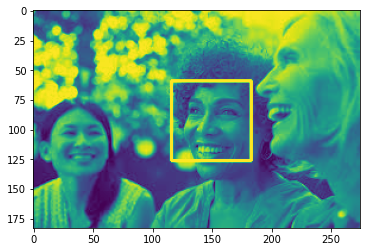

In [25]:
from PIL import ImageOps
from collections import Counter
count=0

no_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/no_mask_model")
top_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/top_mask_model")
bottom_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/bottom_mask_model")
three_fourths_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/three_fourths_mask_model")

#majortiy classification
mc_labels=[]
bc_labels=[]
actual_labels=[]
labels={0:'Happy',1: 'Sad',2: 'Neutral'}
for a,r in test_data.iterrows():
  img= Image.open(test_data.loc[a,'filename'])
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  #img=np.array(img)
  # Convert into grayscale
  gray=ImageOps.grayscale(img)
  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray=np.array(gray)
  #cv2.imshow(gray)
  try:
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)[0]

    #Storing in the Dataframe
    img=np.array(img)
    x,y,w,h=faces

    #startpoint, endpoint, color, thickness
    cv2.rectangle(gray, (x, y), (x + w, y + h), (255, 0, 0), 2)
    plt.imshow(gray)
    cropped_img= gray[y:y+h,x:x+w]
    i=cv2.resize(cropped_img, (64,64), interpolation = cv2.INTER_AREA)
    i_no=i
    i_top=i
    i_tf=i
    i_bot=i
    final_labels=[]


    m_img=np.array(i_no)
    m_img=m_img.reshape((64,64,1))
    m_img=tf.expand_dims(m_img, axis=0)
    pred=no_model.predict(m_img)
    final_labels.append(np.argmax(np.array(pred)))


    #reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/three_fourths_mask_model")
    m_img=np.array(i_tf)
    m_img=i[16:,:]
    m_img=m_img.reshape((48,64,1))
    m_img=tf.expand_dims(m_img, axis=0)
    pred=three_fourths_model.predict(m_img)

    final_labels.append(np.argmax(np.array(pred)))



    #reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/top_mask_model")
    m_img=np.array(i_top)
    m_img=i[32:,:]
    m_img=m_img.reshape((32,64,1))
    m_img=tf.expand_dims(m_img, axis=0)
    pred=top_model.predict(m_img)

    final_labels.append(np.argmax(np.array(pred)))


    #reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/VGG 16 - Model Checkpoints/bottom_mask_model")
    m_img=np.array(i_bot)
    m_img=i[:32,:]
    m_img=m_img.reshape((32,64,1))
    m_img=tf.expand_dims(m_img, axis=0)
    pred=bottom_model.predict(m_img)

    final_labels.append(np.argmax(np.array(pred)))


    counts = Counter(final_labels)

    top_two = counts.most_common(2)
    if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
      # It is a tie
      majority_classification = final_labels[1]
    majority_classification = top_two[0][0]

    best_model_classification=final_labels[1]
    mc_labels.append(majority_classification)
    bc_labels.append(best_model_classification)
    actual_labels.append(test_data.loc[a,'labels'])
  except:
    continue


In [26]:
len(actual_labels)

131

### Assess Model Metrics

In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

In [28]:
accuracy_score(actual_labels,mc_labels)

0.6412213740458015

In [29]:
accuracy_score(actual_labels,bc_labels)

0.6335877862595419

In [30]:
f1_score(actual_labels,mc_labels, average='weighted')

0.6075852713982375

In [31]:
f1_score(actual_labels,bc_labels, average='weighted')

0.6155987354460636

In [32]:
precision_score(actual_labels,mc_labels, average='weighted')

0.6659707765020332

In [33]:
precision_score(actual_labels,bc_labels, average='weighted')

0.6248353819361471

In [34]:
recall_score(actual_labels,mc_labels, average='weighted')

0.6412213740458015

In [35]:
recall_score(actual_labels,bc_labels, average='weighted')

0.6335877862595419

In [36]:
confusion_matrix(actual_labels,mc_labels)

array([[41,  0,  0],
       [ 8, 13, 23],
       [12,  4, 30]])

In [37]:
confusion_matrix(actual_labels,bc_labels)

array([[40,  0,  1],
       [ 6, 20, 18],
       [12, 11, 23]])

In [38]:
print(classification_report(actual_labels,bc_labels))

              precision    recall  f1-score   support

           0       0.69      0.98      0.81        41
           1       0.65      0.45      0.53        44
           2       0.55      0.50      0.52        46

    accuracy                           0.63       131
   macro avg       0.63      0.64      0.62       131
weighted avg       0.62      0.63      0.62       131



In [39]:
print(classification_report(actual_labels,mc_labels))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        41
           1       0.76      0.30      0.43        44
           2       0.57      0.65      0.61        46

    accuracy                           0.64       131
   macro avg       0.67      0.65      0.61       131
weighted avg       0.67      0.64      0.61       131

